<a href="https://colab.research.google.com/github/mofuoku417/Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Price-Using-Machine-Learning-Techniques/blob/main/MLP_Regression_D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [ ]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the root mean squared error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

#Calculate the mean absolute percentage error
def MAPE(y_true, y_pred): 
    mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
#reading the csv file into pandas data frame
df = pd.read_csv("/content/gdrive/MyDrive/raw_data/df3.csv")

In [ ]:
del df['Unnamed: 0']

In [ ]:
df.columns = ['Date', 'cpo_pri', 'cno_pri', 'sbo_pri', 'pno_pri']

In [ ]:
#setting the Date column as the index of the data frame
df['Date'] = df['Date'].apply(pd.to_datetime)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb385a50650>,
      dtype=object)

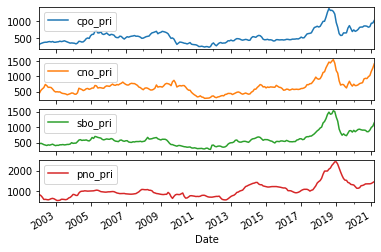

In [ ]:
df.set_index('Date')[['cpo_pri', 'cno_pri','sbo_pri', 'pno_pri']].plot(subplots=True)

In [ ]:
df.head()

,Date,cpo_pri,cno_pri,sbo_pri,pno_pri
0,2002-02-01,323,455,468.0,844.0
1,2002-03-01,345,546,485.0,799.0
2,2002-04-01,362,595,466.0,718.0
3,2002-05-01,376,636,442.0,614.0
4,2002-06-01,383,738,429.0,619.0


In [ ]:
len(df)

230

In [ ]:
df_train = df.iloc[0:184]
df_test = df.iloc[184:]

In [ ]:
df_train

,Date,cpo_pri,cno_pri,sbo_pri,pno_pri
0,2002-02-01,323,455,468.00,844.00
1,2002-03-01,345,546,485.00,799.00
2,2002-04-01,362,595,466.00,718.00
3,2002-05-01,376,636,442.00,614.00
4,2002-06-01,383,738,429.00,619.00
...,...,...,...,...,...
179,2017-01-01,534,606,632.18,1041.92
180,2017-02-01,511,609,602.35,1079.22
181,2017-03-01,514,626,614.71,1102.31
182,2017-04-01,572,656,675.67,1102.31


In [ ]:
df_test

,Date,cpo_pri,cno_pri,sbo_pri,pno_pri
184,2017-06-01,638,731,697.33,1071.64
185,2017-07-01,645,763,715.04,1016.33
186,2017-08-01,661,769,719.03,1055.21
187,2017-09-01,743,828,753.70,1078.17
188,2017-10-01,816,894,788.70,1169.41
189,2017-11-01,833,979,835.55,1268.18
190,2017-12-01,855,929,887.12,1404.95
191,2018-01-01,831,910,921.79,1472.30
192,2018-02-01,852,930,977.48,1523.39
193,2018-03-01,926,1010,1007.69,1633.34


In [ ]:
del df['Date']

In [ ]:
df.cpo_pri

0       323
1       345
2       362
3       376
4       383
       ... 
225     826
226     844
227     944
228     949
229    1026
Name: cpo_pri, Length: 230, dtype: int64

In [ ]:
x = df[['cno_pri', 'sbo_pri', 'pno_pri']]
y = df[['cpo_pri']]

In [ ]:
#y = np.reshape(y, (-1,1))

In [ ]:
#scaler_x = MinMaxScaler()   
#scaler_y = MinMaxScaler()
#print(scaler_x.fit(x))       
#xscale=scaler_x.transform(x)
#print(scaler_y.fit(y))               
#yscale=scaler_y.transform(y)

#scaler = MinMaxScaler(feature_range = (0, 1))
#scaler_single = MinMaxScaler(feature_range = (0, 1))

#scaled_data = np.concatenate([scaler.fit_transform(df[['cno_pri', 'sbo_pri', 'pno_pri']]), 
                                  #scaler_single.fit_transform(df[['cpo_pri']])], axis = 1)

#real_prices = scaler_single.inverse_transform(y)

MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(xscale, yscale, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

(184, 3) (46, 3) (184, 1) (46, 1)


In [ ]:
X_train

array([[0.25513428, 0.227603  , 0.24233586],
       [0.22274882, 0.20597307, 0.28469102],
       [0.30331754, 0.25490479, 0.36731576],
       [0.45102686, 0.52523893, 0.83500788],
       [0.09083728, 0.04198611, 0.11238594],
       [0.28199052, 0.31659016, 0.46697906],
       [0.78988942, 0.79574932, 0.76247869],
       [0.21563981, 0.27086287, 0.26431765],
       [0.12559242, 0.12586219, 0.03163234],
       [0.15560821, 0.24364921, 0.2090951 ],
       [0.06477093, 0.02394514, 0.11130829],
       [0.28515008, 0.16730355, 0.36060327],
       [0.30647709, 0.36911085, 0.52608327],
       [0.13823065, 0.17472983, 0.11312581],
       [0.2385466 , 0.23370745, 0.304035  ],
       [0.27014218, 0.25456031, 0.36060327],
       [0.30252765, 0.25964735, 0.21606494],
       [0.2614534 , 0.31171942, 0.2830826 ],
       [0.35781991, 0.11384556, 0.03056005],
       [0.15481833, 0.04092063, 0.12420249],
       [0.34518167, 0.19315533, 0.16727608],
       [0.06793049, 0.0336706 , 0.10313214],
       [0.

In [ ]:
len(y_test)

46

In [ ]:
df_test['cpo_pri']

184     638
185     645
186     661
187     743
188     816
189     833
190     855
191     831
192     852
193     926
194     999
195    1002
196    1122
197    1269
198    1377
199    1320
200    1326
201    1293
202    1213
203     964
204     826
205     636
206     581
207     587
208     659
209     656
210     660
211     800
212     873
213     789
214     698
215     746
216     704
217     725
218     763
219     822
220     831
221     830
222     863
223     863
224     855
225     826
226     844
227     944
228     949
229    1026
Name: cpo_pri, dtype: int64

In [ ]:
len(df_test['cpo_pri'])

46

In [ ]:
230-184

46

In [ ]:
pipe_MLPRegressor = Pipeline([('scaler',  MinMaxScaler()),
            ('MLPRegressor', MLPRegressor(random_state = 42))])

In [ ]:
grid_params_MLPRegressor = [{
    'MLPRegressor__solver': ['sgd', 'adam'],
    'MLPRegressor__alpha': [0.0001, 0.05],
    'MLPRegressor__max_iter': [100,200,300, 500, 1000],
    'MLPRegressor__activation' : ['relu','logistic','tanh'],
    'MLPRegressor__learning_rate' : ['constant', 'adaptive'],
    'MLPRegressor__hidden_layer_sizes':[(50,50,50), (50,100,50), (100,)],}]


CV_mlpregressor_grid = GridSearchCV (estimator = pipe_MLPRegressor,
                               param_grid = grid_params_MLPRegressor, n_jobs=-1,
                               cv = 5,return_train_score=True, verbose=0)


CV_mlpregressor_grid.fit(X_train, y_train)

ypred=CV_mlpregressor_grid.predict(X_test)

print (np.c_[y_test, ypred])

#print (np.c_[y_test, ypred])
print('Train Accuracy : %.3f'%CV_mlpregressor_grid.best_estimator_.score(X_train, y_train))
print('Test Accuracy : %.3f'%CV_mlpregressor_grid.best_estimator_.score(X_test, y_test))
print('Best Accuracy Through Grid Search : %.3f'%CV_mlpregressor_grid.best_score_)
print('Best Parameters : ',CV_mlpregressor_grid.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[0.18285214 0.16706424]
 [0.92650919 0.96308364]
 [0.07786527 0.071098  ]
 [0.3735783  0.37828687]
 [0.20297463 0.18806102]
 [0.13473316 0.19387831]
 [0.4295713  0.43830963]
 [0.29046369 0.26559903]
 [0.52143482 0.47101078]
 [0.20384952 0.23117992]
 [0.24584427 0.23222372]
 [0.02712161 0.05141235]
 [0.29133858 0.28001992]
 [0.13648294 0.17330945]
 [0.167979   0.12447179]
 [0.19247594 0.16435065]
 [0.08573928 0.12645769]
 [0.12948381 0.17589809]
 [0.32983377 0.25956117]
 [0.18547682 0.26126671]
 [0.23184602 0.26585735]
 [0.04724409 0.04835914]
 [0.37182852 0.39875221]
 [0.55905512 0.47422448]
 [0.0183727  0.05022551]
 [0.28608924 0.27286609]
 [0.20734908 0.27792768]
 [0.33420822 0.28751023]
 [0.13735783 0.12341991]
 [0.17935258 0.16556883]
 [0.24234471 0.26477407]
 [0.22047244 0.18790714]
 [0.54330709 0.50254161]
 [0.28696413 0.30102899]
 [0.21084864 0.25063656]
 [0.15223097 0.11113756]
 [0.14610674 0.12004486]
 [0.24496938 0.27814347]
 [0.14698163 0.16658682]
 [0.12860892 0.18438992]


In [ ]:
'''
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
(1901, 456, 3) (476, 456, 3) (1901, 3, 3) (476, 3, 3)

model = Sequential()

model.add(Flatten(input_shape=(456,3)))

model.add(Dense(64, activation='relu'))

model.add(Dense(32, activation='relu'))

model.add(Dense(3 * 3))

model.add(Reshape((3, 3)))

model.compile('adam', 'mse')

history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100)
'''

"\nX_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)\n\nprint(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)\n(1901, 456, 3) (476, 456, 3) (1901, 3, 3) (476, 3, 3)\n\nmodel = Sequential()\n\nmodel.add(Flatten(input_shape=(456,3)))\n\nmodel.add(Dense(64, activation='relu'))\n\nmodel.add(Dense(32, activation='relu'))\n\nmodel.add(Dense(3 * 3))\n\nmodel.add(Reshape((3, 3)))\n\nmodel.compile('adam', 'mse')\n\nhistory = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100)\n"

In [ ]:
from keras.layers import Dense, Activation, Flatten

In [ ]:
model = Sequential()
model.add(Dense(12, input_dim=3, kernel_initializer='normal', activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 12)                48        
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=50,  verbose=1, validation_split=0.2)

Epoch 1/250
3/3 [==============================] - 0s 26ms/step - loss: 0.0034 - mse: 0.0034 - mae: 0.0463 - val_loss: 0.0033 - val_mse: 0.0033 - val_mae: 0.0458
Epoch 2/250
3/3 [==============================] - 0s 14ms/step - loss: 0.0034 - mse: 0.0034 - mae: 0.0462 - val_loss: 0.0033 - val_mse: 0.0033 - val_mae: 0.0457
Epoch 3/250
3/3 [==============================] - 0s 13ms/step - loss: 0.0034 - mse: 0.0034 - mae: 0.0461 - val_loss: 0.0033 - val_mse: 0.0033 - val_mae: 0.0456
Epoch 4/250
3/3 [==============================] - 0s 11ms/step - loss: 0.0034 - mse: 0.0034 - mae: 0.0460 - val_loss: 0.0032 - val_mse: 0.0032 - val_mae: 0.0453
Epoch 5/250
3/3 [==============================] - 0s 11ms/step - loss: 0.0034 - mse: 0.0034 - mae: 0.0460 - val_loss: 0.0032 - val_mse: 0.0032 - val_mae: 0.0454
Epoch 6/250
3/3 [==============================] - 0s 15ms/step - loss: 0.0034 - mse: 0.0034 - mae: 0.0459 - val_loss: 0.0032 - val_mse: 0.0032 - val_mae: 0.0452
Epoch 7/250
3/3 [===========

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


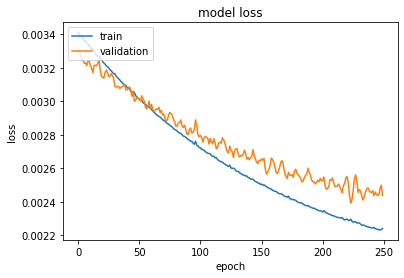

In [ ]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
ypred = model.predict(X_test)

In [ ]:
mlp_pred = scaler_y.inverse_transform(ypred)

In [ ]:
testY = scaler_y.inverse_transform(y_test)

In [ ]:
testY

array([[ 443.],
       [1293.],
       [ 323.],
       [ 661.],
       [ 466.],
       [ 388.],
       [ 725.],
       [ 566.],
       [ 830.],
       [ 467.],
       [ 515.],
       [ 265.],
       [ 567.],
       [ 390.],
       [ 426.],
       [ 454.],
       [ 332.],
       [ 382.],
       [ 611.],
       [ 446.],
       [ 499.],
       [ 288.],
       [ 659.],
       [ 873.],
       [ 255.],
       [ 561.],
       [ 471.],
       [ 616.],
       [ 391.],
       [ 439.],
       [ 511.],
       [ 486.],
       [ 855.],
       [ 562.],
       [ 475.],
       [ 408.],
       [ 401.],
       [ 514.],
       [ 402.],
       [ 381.],
       [ 581.],
       [ 561.],
       [ 548.],
       [ 465.],
       [ 660.],
       [ 964.]])

In [ ]:
len(mlp_pred)

46

In [ ]:
mlp_pred

array([[ 413.39923],
       [1364.7351 ],
       [ 308.61624],
       [ 660.9573 ],
       [ 407.86792],
       [ 434.54547],
       [ 763.3224 ],
       [ 528.4723 ],
       [ 785.3579 ],
       [ 482.062  ],
       [ 448.5163 ],
       [ 273.62494],
       [ 542.97205],
       [ 457.3683 ],
       [ 410.17242],
       [ 408.9709 ],
       [ 376.20676],
       [ 464.6273 ],
       [ 528.25494],
       [ 475.0128 ],
       [ 542.0846 ],
       [ 273.25143],
       [ 632.53064],
       [ 769.9043 ],
       [ 274.15442],
       [ 531.42004],
       [ 494.91962],
       [ 558.48694],
       [ 411.12354],
       [ 364.6417 ],
       [ 518.2352 ],
       [ 448.43933],
       [ 795.6879 ],
       [ 572.9341 ],
       [ 505.5092 ],
       [ 395.35092],
       [ 402.18094],
       [ 530.1455 ],
       [ 454.01935],
       [ 414.18765],
       [ 615.4278 ],
       [ 494.46243],
       [ 470.7    ],
       [ 480.43283],
       [ 563.4246 ],
       [1087.379  ]], dtype=float32)

In [ ]:
df4 = pd.DataFrame(np.concatenate([testY, mlp_pred], axis=1), columns= ['Actual','Predicted'])

In [ ]:
df4

,Actual,Predicted
0,443.0,413.399231
1,1293.0,1364.735107
2,323.0,308.616241
3,661.0,660.957275
4,466.0,407.867920
5,388.0,434.545471
6,725.0,763.322388
7,566.0,528.472290
8,830.0,785.357910
9,467.0,482.062012


In [ ]:
df['cpo_pri']

0       323
1       345
2       362
3       376
4       383
       ... 
225     826
226     844
227     944
228     949
229    1026
Name: cpo_pri, Length: 230, dtype: int64

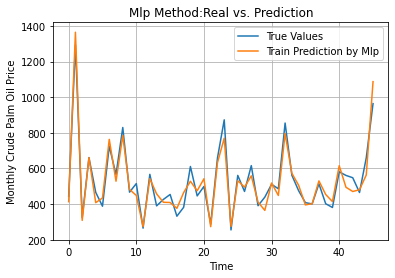

In [ ]:
plt.grid()
#plt.plot(df_test.index, df_test['cpo_pri'], label = 'Train')
plt.plot(testY,  label = 'Test')
plt.plot(mlp_pred,label = 'lstm forecast')
plt.legend(['True Values', 'Train Prediction by Mlp', 'Test Prediction by MLP'],loc='best')
plt.title('Mlp Method:Real vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Time')
plt.show()

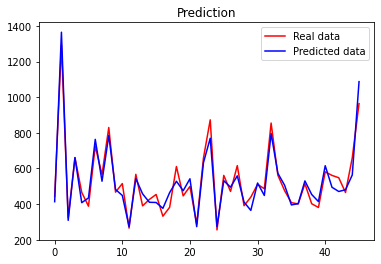

In [ ]:
plt.plot(testY, color = 'red', label = 'Real data')
plt.plot(mlp_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

In [ ]:
MAE_mlp = mean_absolute_error(testY, mlp_predictions)
print('MAE value of the MLP Model is:', MAE_mlp)

MDA_mlp = np.mean((np.sign(testY[1:] - testY[:-1]) == np.sign(mlp_pred[1:] - mlp_pred[:-1])).astype(int))
print('MDA value of the MLP Model is:', (MDA_mlp))

MAPE_mlp = mean_absolute_percentage_error(testY, mlp_pred)
print('MAPE value of the MLP Model is:', (MAPE_mlp))

RMSE_mlp = mean_squared_error(testY, mlp_pred, squared=False)
print('RMSE value of the MLP Model is:', (RMSE_mlp))

MSE_mlp = mean_squared_error(testY, mlp_pred)
print('MSE value of the MLP Model is:', (MSE_mlp))

MAE value of the MLP Model is: 529.6569752801696
MDA value of the MLP Model is: 0.8444444444444444
MAPE value of the MLP Model is: 7.872332013820057
RMSE value of the MLP Model is: 50.287247281929794
MSE value of the MLP Model is: 2528.8072391939554


In [ ]:
MAE_mlp = mean_absolute_error(y_test, mlp_predictions)
print('MAE value of the MLP Model is:', MAE_mlp)

MDA_mlp = np.mean((np.sign(y_test[1:] - y_test[:-1]) == np.sign(mlp_predictions[1:] - mlp_predictions[:-1])).astype(int))
print('MDA value of the MLP Model is:', (MDA_mlp))

MAPE_mlp = mean_absolute_percentage_error(y_test, mlp_predictions)
print('MAPE value of the MLP Model is:', (MAPE_mlp))

RMSE_mlp = mean_squared_error(y_test, mlp_predictions, squared=False)
print('RMSE value of the MLP Model is:', (RMSE_mlp))

MSE_mlp = mean_squared_error(y_test, mlp_predictions)
print('MSE value of the MLP Model is:', (MSE_mlp))

MAE value of the MLP Model is: 0.037814369165644346
MDA value of the MLP Model is: 0.8888888888888888
MAPE value of the MLP Model is: 20.745756171719943
RMSE value of the MLP Model is: 0.04607524883934234
MSE value of the MLP Model is: 0.002122928555607317


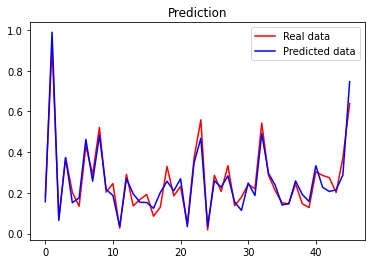

In [ ]:
plt.plot(y_test, color = 'red', label = 'Real data')
plt.plot(ypred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

In [ ]:
X = df['cpo_pri'].values

# difine x_scaler
#x_scaler = MinMaxScaler()
scaler_x = MinMaxScaler()

M = scaler_x.fit_transform(X.reshape(-1, 1))
N = scaler_x.fit(X.reshape(-1, 1))
result = N.inverse_transform(M)

In [ ]:
###############################################################################################################################################

In [ ]:
x = df[['cno_pri', 'sbo_pri', 'pno_pri']]
y = df[['cpo_pri']]

In [ ]:
trainX, testX, trainY, testY = train_test_split(x, y, test_size = 0.2)

In [ ]:
sc=StandardScaler()

scaler = sc.fit(trainX)
trainX_scaled = scaler.transform(trainX)
testX_scaled = scaler.transform(testX)

In [ ]:
mlp_reg = MLPRegressor(hidden_layer_sizes=(150,100,50),
                       max_iter = 400,activation = 'relu',
                       solver = 'adam')

mlp_reg.fit(trainX_scaled, trainY)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(150, 100, 50), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=400,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [ ]:
y_pred = mlp_reg.predict(testX_scaled)

In [ ]:
y_pred

array([1007.01311927,  409.8084142 ,  532.64217875,  623.48522928,
        359.35978673,  335.16468739, 1262.60996934,  483.58754909,
        491.18390492,  433.84307616,  500.59077441,  487.56068705,
       1270.28856769,  774.40260708,  543.13235485,  464.73636265,
        873.78566715,  529.61124829,  593.46112854,  760.4043823 ,
        628.52182476,  425.89786354,  555.43714437,  709.00033448,
        342.95303629,  494.37920532,  499.880717  ,  531.85324459,
        588.93605916,  516.97737943,  347.12264402,  773.52484661,
        548.7315202 ,  431.39362165,  528.07799407,  489.38779789,
        823.32637765,  545.97887186,  397.31303339,  530.31476904,
        549.97980353,  416.6754235 ,  289.18346339,  483.65479562,
        281.76797726,  494.32163391])

In [ ]:
pd.concat([testY, pd.DataFrame(y_pred)], axis=1)

,cpo_pri,0
0,NaN,1007.013119
1,NaN,409.808414
2,NaN,532.642179
3,NaN,623.485229
4,NaN,359.359787
...,...,...
217,725.0,NaN
218,763.0,NaN
221,830.0,NaN
222,863.0,NaN


In [ ]:
testY

,cpo_pri
190,855
20,371
218,763
73,547
222,863
217,725
19,392
171,457
42,687
52,535


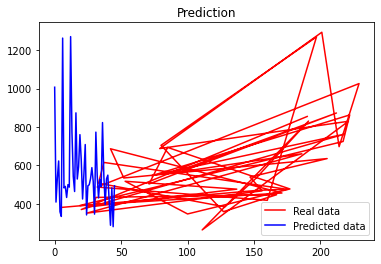

In [ ]:
plt.plot(testY, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

In [ ]:
MAE_mlp = mean_absolute_error(testY, y_pred)
print('MAE value of the MLP Model is:', MAE_mlp)

#MDA_mlp = np.mean((np.sign(testY[1:] - testY[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int))
#print('MDA value of the MLP Model is:', (MDA_mlp))

MAPE_mlp = mean_absolute_percentage_error(testY, y_pred)
print('MAPE value of the MLP Model is:', (MAPE_mlp))

RMSE_mlp = mean_squared_error(testY, y_pred, squared=False)
print('RMSE value of the MLP Model is:', (RMSE_mlp))

MSE_mlp = mean_squared_error(testY, y_pred)
print('MSE value of the MLP Model is:', (MSE_mlp))

MAE value of the MLP Model is: 221.20970881709053
MAPE value of the MLP Model is: 38.80292788244282
RMSE value of the MLP Model is: 310.3740157261579
MSE value of the MLP Model is: 96332.02963798131


In [ ]:
len(y_pred)

46

In [ ]:
y_pred

array([1007.01311927,  409.8084142 ,  532.64217875,  623.48522928,
        359.35978673,  335.16468739, 1262.60996934,  483.58754909,
        491.18390492,  433.84307616,  500.59077441,  487.56068705,
       1270.28856769,  774.40260708,  543.13235485,  464.73636265,
        873.78566715,  529.61124829,  593.46112854,  760.4043823 ,
        628.52182476,  425.89786354,  555.43714437,  709.00033448,
        342.95303629,  494.37920532,  499.880717  ,  531.85324459,
        588.93605916,  516.97737943,  347.12264402,  773.52484661,
        548.7315202 ,  431.39362165,  528.07799407,  489.38779789,
        823.32637765,  545.97887186,  397.31303339,  530.31476904,
        549.97980353,  416.6754235 ,  289.18346339,  483.65479562,
        281.76797726,  494.32163391])

In [ ]:
np.random.seed(123)
e = np.random.normal(size=10)  
dataframe=pd.DataFrame(e, columns=['a']) 
print (dataframe)

          a
0 -1.085631
1  0.997345
2  0.282978
3 -1.506295
4 -0.578600
5  1.651437
6 -2.426679
7 -0.428913
8  1.265936
9 -0.866740


In [ ]:
df1 = pd.DataFrame(y_pred, columns=['Predicted']) 
print (df1)

      Predicted
0   1007.013119
1    409.808414
2    532.642179
3    623.485229
4    359.359787
5    335.164687
6   1262.609969
7    483.587549
8    491.183905
9    433.843076
10   500.590774
11   487.560687
12  1270.288568
13   774.402607
14   543.132355
15   464.736363
16   873.785667
17   529.611248
18   593.461129
19   760.404382
20   628.521825
21   425.897864
22   555.437144
23   709.000334
24   342.953036
25   494.379205
26   499.880717
27   531.853245
28   588.936059
29   516.977379
30   347.122644
31   773.524847
32   548.731520
33   431.393622
34   528.077994
35   489.387798
36   823.326378
37   545.978872
38   397.313033
39   530.314769
40   549.979804
41   416.675423
42   289.183463
43   483.654796
44   281.767977
45   494.321634


In [ ]:
df_temp = pd.DataFrame({'Actual': testY, 'Predicted': df1})
df_temp.head()

ValueError: ignored